In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import math

In [2]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

Graph size: 10, Probability: 0.0141
Graph size: 20, Probability: 0.0194
Graph size: 40, Probability: 0.0677
Graph size: 80, Probability: 0.1933


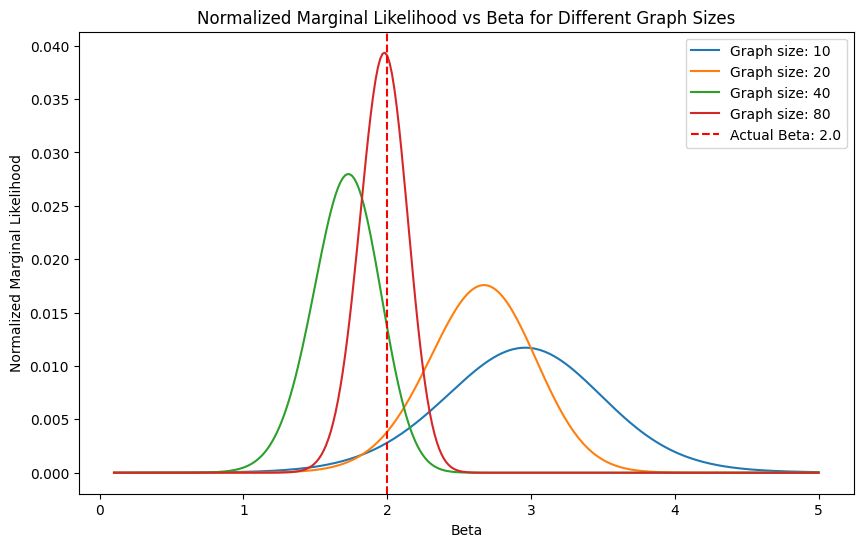

In [4]:
# Parameters
beta_sample = 2.0
noise_std = 0.1
sizes = [10, 20, 40, 80]  # Graph sizes to consider

def generate_random_graph_by_degree(num_nodes, average_degree):
    probability = average_degree / (num_nodes - 1)  # Calculate edge probability from average degree
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)
    return nx.to_numpy_array(G)

# Evaluate Marginal Likelihood (ML) for a range of beta values
def evaluate_ml(adjacency_matrix, X, Y, beta_values, noise_variance):
    ml_values = []
    for beta in beta_values:
        kernel = GraphDiffusionKernel(adjacency_matrix, beta=beta)
        model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
        model.likelihood.variance.assign(noise_variance)
        ml_values.append(np.exp(model.log_marginal_likelihood().numpy()))
    return ml_values

# Calculate probability using 5 samples near the ground truth
def calculate_probability_near_truth(ml_values, beta_values, ground_truth, n_samples=5):
    idx = np.abs(beta_values - ground_truth).argsort()[:n_samples]
    prob_near_truth = np.sum(np.array(ml_values)[idx]) / np.sum(ml_values)
    return prob_near_truth

# Set up plot
plt.figure(figsize=(10, 6))
beta_values = np.linspace(0.1, 5, 300)

# Process each graph size
for num_nodes in sizes:
    # Generate graph and adjacency matrix
    adjacency_matrix = generate_random_graph_by_degree(num_nodes, 10)

    # Generate true kernel and noisy observations
    K_true = diffusion_kernel(adjacency_matrix, beta_sample)
    Y_noisy = generate_noisy_samples(K_true, noise_std=noise_std)
    X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))
    Y = tf.convert_to_tensor(Y_noisy, dtype=tf.float64)

    # Compute ML values
    ml_values = evaluate_ml(adjacency_matrix, X, Y, beta_values, noise_variance=noise_std**2)

    # Normalize ML values for plotting
    ml_values_normalized = ml_values / np.sum(ml_values)

    # Calculate probability
    probability = calculate_probability_near_truth(ml_values, beta_values, beta_sample, n_samples=5)
    print(f"Graph size: {num_nodes}, Probability: {probability:.4f}")

    # Plot normalized ML curve
    plt.plot(beta_values, ml_values_normalized, label=f'Graph size: {num_nodes}')

# Finalize plot
plt.axvline(x=beta_sample, color='red', linestyle='--', label=f'Actual Beta: {beta_sample}')
plt.xlabel('Beta')
plt.ylabel('Normalized Marginal Likelihood')
plt.title('Normalized Marginal Likelihood vs Beta for Different Graph Sizes')
plt.legend()
plt.show()


Noise level: 0.01, Probability: 0.0871
Noise level: 0.05, Probability: 0.0801
Noise level: 0.1, Probability: 0.0413
Noise level: 0.2, Probability: 0.0599
Noise level: 0.3, Probability: 0.0550


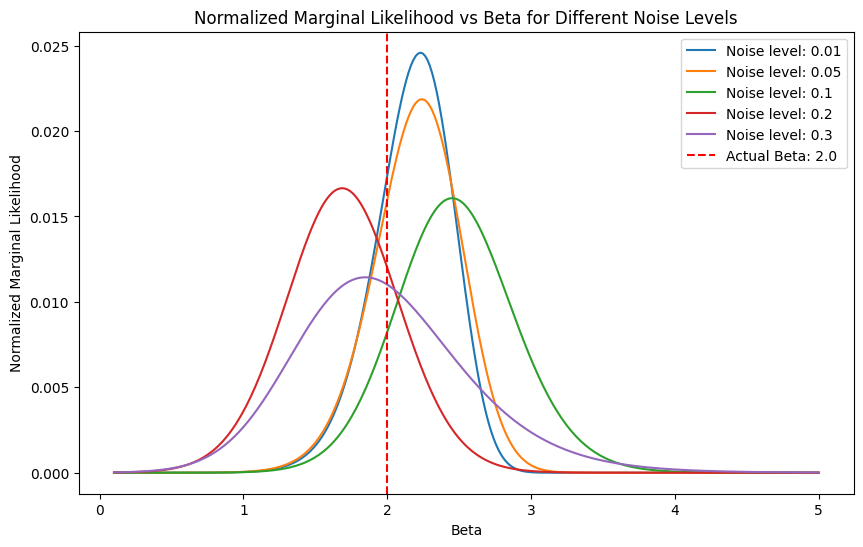

In [23]:
# Parameters
beta_sample = 2.0
sizes = [20]  # Fixed graph size
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.3]  # Different noise levels to consider

# Evaluate Marginal Likelihood (ML) for a range of beta values
def evaluate_ml(adjacency_matrix, X, Y, beta_values, noise_variance):
    ml_values = []
    for beta in beta_values:
        kernel = GraphDiffusionKernel(adjacency_matrix, beta=beta)
        model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
        model.likelihood.variance.assign(noise_variance)
        ml_values.append(np.exp(model.log_marginal_likelihood().numpy()))
    return ml_values

# Calculate probability using 5 samples near the ground truth
def calculate_probability_near_truth(ml_values, beta_values, ground_truth, n_samples=5):
    idx = np.abs(beta_values - ground_truth).argsort()[:n_samples]
    prob_near_truth = np.sum(np.array(ml_values)[idx]) / np.sum(ml_values)
    return prob_near_truth

# Set up plot
plt.figure(figsize=(10, 6))
beta_values = np.linspace(0.1, 5, 300)

# Process each noise level
for noise_std in noise_levels:
    # Generate graph and adjacency matrix
    G = nx.erdos_renyi_graph(20, p=0.1, directed=False)
    adjacency_matrix = nx.to_numpy_array(G)

    # Generate true kernel and noisy observations
    K_true = diffusion_kernel(adjacency_matrix, beta_sample)
    Y_noisy = generate_noisy_samples(K_true, noise_std=noise_std)
    X = tf.convert_to_tensor(np.arange(20, dtype=np.float64).reshape(-1, 1))
    Y = tf.convert_to_tensor(Y_noisy, dtype=tf.float64)

    # Compute ML values
    ml_values = evaluate_ml(adjacency_matrix, X, Y, beta_values, noise_variance=noise_std**2)

    # Normalize ML values for plotting
    ml_values_normalized = ml_values / np.sum(ml_values)

    # Calculate probability
    probability = calculate_probability_near_truth(ml_values, beta_values, beta_sample, n_samples=5)
    print(f"Noise level: {noise_std}, Probability: {probability:.4f}")

    # Plot normalized ML curve
    plt.plot(beta_values, ml_values_normalized, label=f'Noise level: {noise_std}')

# Finalize plot
plt.axvline(x=beta_sample, color='red', linestyle='--', label=f'Actual Beta: {beta_sample}')
plt.xlabel('Beta')
plt.ylabel('Normalized Marginal Likelihood')
plt.title('Normalized Marginal Likelihood vs Beta for Different Noise Levels')
plt.legend()
plt.show()
